In [1]:
from __future__ import print_function, division
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.pylabtools import figsize
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

# Parent & Child Relationship

* **Parent variables**: variables that influence another variable.
* **Child variables**: variables that are affected by other variable (the subject of parent variables).

A variable can be both a parent and child.

In [2]:
lambda_ = pm.Exponential("poisson_param", 1)
# used in the call to the next variable...
data_generator = pm.Poisson("data_generator", lambda_)
data_plus_one = data_generator + 1

* `lambda_`: parent of `data_generator`
* `data_generator`: child of `lambda_` & parent of `data_plus_one`

In [3]:
print("Children of 'lambda_': ")
print(lambda_.children)
print("\nParents of 'data_generator': ")
print(data_generator.parents)
print("\nChildren of 'data_generator': ")
print(data_generator.children)

Children of 'lambda_': 
set([<pymc.distributions.Poisson 'data_generator' at 0x00000000118FB148>])

Parents of 'data_generator': 
{'mu': <pymc.distributions.Exponential 'poisson_param' at 0x00000000117E4648>}

Children of 'data_generator': 
set([<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x0000000011901448>])


# PyMC Variables

`value` property of PyMC variables produces the current (possibly random) internal value of the variables. 

In [4]:
print("lambda_.value = ", lambda_.value)
print("data_generator.value = ", data_generator.value)
print("data_plus_one.value = ", data_plus_one.value)

lambda_.value =  2.3513209291348995
data_generator.value =  7
data_plus_one.value =  8


PyMC variables:
* **Stochastic**: Random, even if we knew all the variables' parents values. Instances of classes: `Poisson`, `DiscreteUniform`, `Exponential`.
* **Deterministic**: Not random if the variables' parents are known. Trick: "If I knew all of variable `foo`'s parent variables' values, I could determine exactly what `foo`'s value is."

**Initializing Stochastic Variables**: The 1st argument in initializinf a stochastic variable is a string that represents the name of the variable. After that are additional arguments that are class-specific.

In [5]:
some_variables = pm.DiscreteUniform("discete_uni_var", 0,4)

* 0,4: lower & upper bound on the random variable.

In [6]:
# ??pm.DiscreteUniform

`size` argument replaces:
$$
\beta_{i}, 
i = 1,\cdots,N
$$

In [7]:
beta_1 = pm.Uniform("beta_1", 0, 1)
beta_2 = pm.Uniform("beta_2", 0, 1)

In [8]:
N = 2
betas = pm.Uniform("betas", 0, 1, size=N)

**Caling `random()`**

In [9]:
lambda_1 = pm.Exponential("lambda_1", 1) # prior on the 1st behaviour
lambda_2 = pm.Exponential("lambda_2", 2) # prior on the 2nd behaviour
tau = pm.DiscreteUniform("tau", lower=0, upper=10) # prior on behaviour change

In [10]:
print("Initialized values...")
print("lambda_1.value: %.3f" %lambda_1.value)
print("lambda_2.value: %.3f" %lambda_2.value)
print("tau.value: %.3f" %tau.value)

lambda_1.random(); lambda_2.random(); tau.random()
print("After calling random() on the variables...")
print("lambda_1.value: %.3f" %lambda_1.value)
print("lambda_2.value: %.3f" %lambda_2.value)
print("tau.value: %.3f" %tau.value)

Initialized values...
lambda_1.value: 0.324
lambda_2.value: 0.380
tau.value: 6.000
After calling random() on the variables...
lambda_1.value: 0.040
lambda_2.value: 0.048
tau.value: 5.000


**Deterministic Variables**

In [11]:
"""
@pm.deterministic
def some_deterministic_var(v1=v1,):
    # jelly goes here
"""

'\n@pm.deterministic\ndef some_deterministic_var(v1=v1,):\n    # jelly goes here\n'

In [12]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

$$
\lambda = \begin{cases}
\lambda_{1}\text{ if } t \lt \tau\\
\lambda_{2}\text{ if } t \geq \tau
\end{cases}
$$

In [13]:
n_data_points = 5

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1 # lambda before tau is lambda_1
    out[tau:] = lambda_2 # lambda after tau is lambda_2
    return out

## Including Observations in the Model

What does my prior distribution of $\lambda_{1}$ look like?

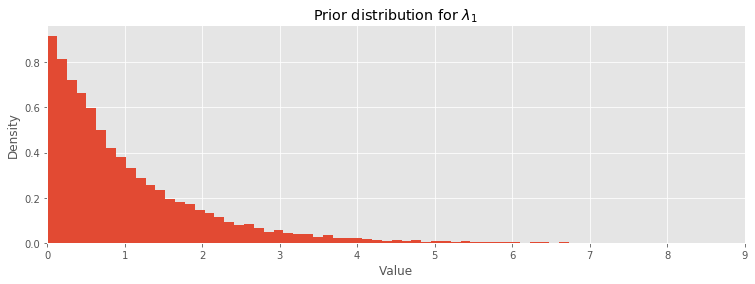

In [14]:
figsize(12.5, 4)
samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled");
plt.title('Prior distribution for $\lambda_1$');
plt.xlabel('Value');
plt.ylabel('Density');
plt.xlim(0, 9);

Bayes' Theorem:
$$P(A|X) = \frac{P(X|A) P(A)}{P(X)}$$
Above is $P(A)$. Next step: include data/evidence/observations $X$ into our model.

In [15]:
data = np.array([10, 5])
fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print("value: ", fixed_variable.value)
print("calling .random()")
fixed_variable.random()
print("value: ", fixed_variable.value)

value:  [10  5]
calling .random()
value:  [10  5]


In [16]:
# We're using some fake data
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print(obs.value)

[10 25 15 20 35]


In [17]:
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])